## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """I DONT USE THIS"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """ I didnt change this function besides the reshape, instead I changed `hough_lines`"""
    for line in lines:
        for x1,y1,x2,y2 in line.reshape(1,4).astype(int):
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [4]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn import clone

### Utilities for draw lane lines after call to `cv2.HoughLinesP`

In [5]:
def infer_and_draw_lines(img, rho, theta, threshold, min_line_len, max_line_gap, consolidate):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    if consolidate, only show lane lines, not all line segments
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if consolidate and len(lines) > 2:

        two_lines = make_two_lines(lines, img.shape)
        draw_lines(line_img, two_lines)
    else:
        draw_lines(line_img, lines)
    color_edges = np.dstack((img, img, img))
    return weighted_img(line_img, color_edges)


def calc_slope(line):
    x1, y1, x2, y2 = line
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - (x1 * slope)
    return slope, intercept


def make_two_lines(lines, im_shape):
    left, right = split_by_slope(lines)
    return consolidate_segments_into_two_lines(left, right, im_shape)


def split_by_slope(lines, min_slp=.5, max_slp=1.):
    left = []
    right = []
    for line in lines:
        slope, intercept = calc_slope(line[0])
        if (slope <= -min_slp) and (slope >= -max_slp):
            # higher y to lower y, lower x to higher x (bot left to top right)
            left.append(line)
        elif (slope >= min_slp) and (slope <= max_slp):
            right.append(line)
        else:
            pass
    return left, right


def extrapolate(l, imshape, clf=HuberRegressor()):
    x = []
    y = []
    for x1, y1, x2, y2 in np.array(l).reshape(len(l), 4):
        x.append(x1)
        y.append(y1)
        x.append(x2)
        y.append(y2)
    if len(x) == 0:
        return np.array([0, 0, 0, 0])
    X = np.array(x)
    y = np.array(y).reshape(len(x), 1)
    try:
        clf = clone(clf).fit(y, X)
    except Exception:  # Doesnt converge
        clf = LinearRegression().fit(y, X)
    y1, x1 = imshape[0], clf.predict(imshape[0])[0]
    y2, x2 = min(y), clf.predict(min(y))[0]
    return np.array([x1, y1, x2, y2])


def consolidate_segments_into_two_lines(l, r, im_shape):
    return np.array([extrapolate(l, im_shape),
                     extrapolate(r, im_shape)])

### Full processing pipeline

In [6]:
def process_image(img,
                  low_threshold=70, high_threshold=210, rho=2., theta=np.pi/360.,
                  min_line_length=60, max_line_gap=40, kernel_size=5, threshold=15,
                  left=1/3, right=2/3., top=.63,  consolidate=True, do_grayscale=False):
    '''The full pipeline to annotate an image'''
    imshape = img.shape
    top_left = (left * imshape[1], top  * imshape[0])
    top_right = (right * imshape[1], top * imshape[0])
    vertices = np.array([[(0, imshape[0]), top_left, top_right,
                            (imshape[1], imshape[0])]], dtype=np.int32)

    if do_grayscale:
        gray = grayscale(img)
    else:
        gray = np.copy(img)
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    masked_edges = region_of_interest(edges, vertices)
    line_image = infer_and_draw_lines(masked_edges, rho, theta,
                                      threshold, min_line_length,
                                      max_line_gap,
                                      consolidate=consolidate)

    return weighted_img(img, line_image, α=.8, β=1.)

### Test before Extrapolating
> In a rough sense, the left and right lane lines are accurately annotated throughout almost all of the video. Annotations can be segmented or solid lines

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
from mat

In [8]:
def show_video(challenge_output):
    retur HTML("""
s<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output));

def process_video(path, **kwargs):
    challenge_output = 'test_videos_output/debug_{}'.format(path)
    clip3 = VideoFileClip('test_videos/{}'.format(path))
    challenge_clip = clip3.fl_image(lambda x: process_image(x, **kwargs))
    challenge_clip.write_videofile(challenge_output, 
                                   audio=False, progress_bar=False)
    return show_video(challenge_output);

In [9]:
process_video('solidWhiteRight.mp4', consolidate=False)  # performance similar to example on easy input

[MoviePy] >>>> Building video test_videos_output/debug_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/debug_solidWhiteRight.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/debug_solidWhiteRight.mp4 



In [10]:
process_video('solidYellowLeft.mp4', consolidate=False)

[MoviePy] >>>> Building video test_videos_output/debug_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/debug_solidYellowLeft.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/debug_solidYellowLeft.mp4 



### Test Images after Extrapolating
> Visually, the left and right lane lines are accurately annotated by solid lines throughout most of the video.

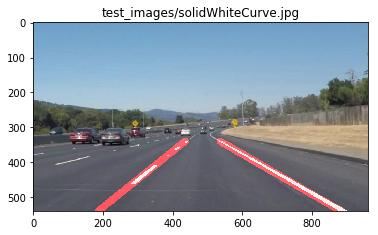

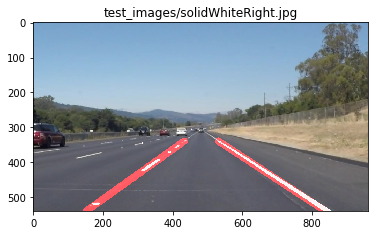

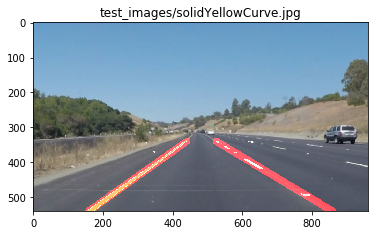

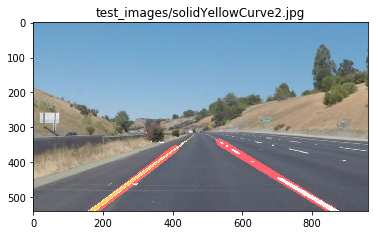

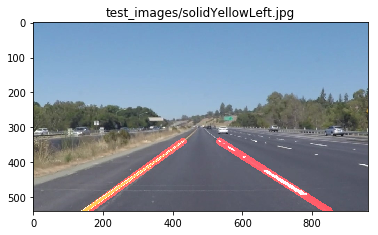

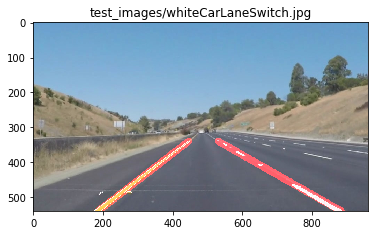

In [58]:
import os
import glob
paths = glob.glob('test_images/*')
def run_pipeline(paths, save=False, show=True, **kwargs):
    for path in paths:
        result = process_image(mpimg.imread(path), **kwargs)
        if show:
            plt.imshow(result)
            plt.title(path)
            plt.show();
        if save:
            write_path = 'annotated_{}_{}'.format(path, kwargs.get('consolidate', ''))
            #print(write_path)
            cv2.imwrite(write_path, result)
            assert os.path.exists(write_path)
run_pipeline(paths, save=True, show=True, consolidate=True)

## Test on Videos after Extrapolating




In [19]:
process_video('solidWhiteRight.mp4', consolidate=True)  

[MoviePy] >>>> Building video test_videos_output/debug_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/debug_solidWhiteRight.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/debug_solidWhiteRight.mp4 



In [14]:
process_video('solidYellowLeft.mp4', consolidate=True)

[MoviePy] >>>> Building video test_videos_output/debug_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/debug_solidYellowLeft.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/debug_solidYellowLeft.mp4 



## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
path = 'challenge.mp4'


In [16]:
#process_video(path, consolidate=False)

In [18]:
process_video(path, consolidate=True)

[MoviePy] >>>> Building video test_videos_output/debug_challenge.mp4
[MoviePy] Writing video test_videos_output/debug_challenge.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/debug_challenge.mp4 

